In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np  # 导入numpy库
import pandas as pd  # 导入pandas库
from sklearn.ensemble import GradientBoostingRegressor  # 集成方法回归库
from sklearn.model_selection import GridSearchCV  # 导入交叉检验库
import matplotlib.pyplot as plt  # 导入图形展示库
from sklearn.ensemble import GradientBoostingRegressor

TRAIN_DATA_PATH = './data/zhengqi_train.txt'
TEST_DATA_PATH = './data/zhengqi_test.txt'


def LoadData():
    # load data from txt file
    train_data = pd.read_csv(TRAIN_DATA_PATH, sep='\t')
    test_data = pd.read_csv(TEST_DATA_PATH, sep='\t')
    return (train_data, test_data)

def main():
    (train_data, test_data) = LoadData()

    train_data_x = train_data.drop(['target'], axis=1)
    train_data_y = train_data['target']

    if True:
        X_train, X_test, Y_train, Y_test = train_test_split(train_data_x, train_data_y, test_size=0.2, random_state=40)
        model_gbr = GradientBoostingRegressor()  # 建立GradientBoostingRegressor回归对象
        if True:
            parameters = {'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1],
                          'loss': ['ls', 'lad', 'huber', 'quantile'],
                          'max_depth': [1, 3, 9, 12, 15, 18, 21],
                          'max_features': ['sqrt'],
                          'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14],
                          'min_samples_split': [10, 20, 30, 40, 50, 60, 70],
                          'n_estimators': [100, 200, 300, 400, 500, 600, 700],
                          'random_state': [10, 20, 30, 40, 50, 60, 70],
                          'subsample': [0.1, 0.3, 0.6, 0.9],
                          'alpha': [0.1, 0.3]}  # 定义要优化的参数信息            
            model_gs = GridSearchCV(estimator=model_gbr, param_grid=parameters, cv=5)  # 建立交叉检验模型对象
            model_gs.fit(X_train, Y_train)  # 训练交叉检验模型
            print('Best score is:', model_gs.best_score_)  # 获得交叉检验模型得出的最优得分
            print('Best parameter is:', model_gs.best_params_)  # 获得交叉检验模型得出的最优参数

            model_best = model_gs.best_estimator_  # 获得交叉检验模型得出的最优模型对象
            model_best.fit(X_train, Y_train)  # 训练最优模型
            Y_pred = model_best.predict(X_test)
            print(mean_squared_error(Y_test, Y_pred))

    if False:
        X_train, X_test, Y_train, Y_test = train_test_split(train_data_x, train_data_y, test_size=0.2, random_state=40)
        params = {'learning_rate': 0.03, 'loss': 'huber', 'max_depth': 14, 'max_features': 'sqrt',
                  'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 300,
                  'random_state': 10, 'subsample': 0.8}
        clf = GradientBoostingRegressor(**params)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print(mean_squared_error(Y_test, Y_pred))

    '''结果预测'''
    if False:
        test_data_y = clf.predict(test_data)
        res_pd = pd.DataFrame(test_data_y, columns=['target'])
        res_pd.to_csv("./submit/njit_77.txt", index=False, header=False)

if __name__ == '__main__':
    main()

0.09127313026288589


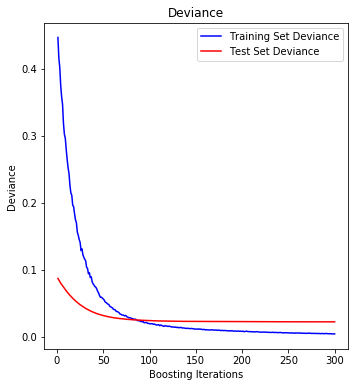

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import pca
from sklearn.ensemble import GradientBoostingRegressor

TRAIN_DATA_PATH = './data/zhengqi_train.txt'
TEST_DATA_PATH = './data/zhengqi_test.txt'


def LoadData():
    # load data from txt file
    train_data = pd.read_csv(TRAIN_DATA_PATH, sep='\t')
    test_data = pd.read_csv(TEST_DATA_PATH, sep='\t')
    return (train_data, test_data)


def NormalizeData(train_data):
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    return (train_data - mean)/std

def DrawLearningRate(clf, params, train_data, X_test, y_test, y_pred):
    ###############################################################################
    # Plot training deviance

    # compute test set deviance
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_predict(X_test)):
        test_score[i] = clf.loss_(y_test, y_pred)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')    
    
def main():
    (train_data, test_data) = LoadData()

    train_data_x = train_data.drop(['target'], axis=1)
    train_data_y = train_data['target']

    train_data_x = NormalizeData(train_data_x)
    
    X_train, X_test, Y_train, Y_test = train_test_split(train_data_x, train_data_y, test_size=0.2, random_state=40)
    params={'learning_rate':0.03, 'loss':'huber', 'max_depth':14, 'max_features':'sqrt', 'min_samples_leaf':10,  
            'min_samples_split':40, 'n_estimators':300, 'random_state':10, 'subsample':0.8}
    clf = GradientBoostingRegressor(**params)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    print(mean_squared_error(Y_test, Y_pred))

    DrawLearningRate(clf, params, train_data, X_test, Y_test, Y_pred)
    
    '''结果预测'''
    test_data_y = clf.predict(test_data)

    res_pd = pd.DataFrame(test_data_y, columns=['target'])
    res_pd.to_csv("./submit/njit_77.txt", index=False, header=False)

if __name__ == '__main__':
    main()

**步骤1** 导入库

In [1]:
import numpy as np  # 导入numpy库
import pandas as pd  # 导入pandas库
from sklearn.ensemble import GradientBoostingRegressor  # 集成方法回归库
from sklearn.model_selection import GridSearchCV  # 导入交叉检验库
import matplotlib.pyplot as plt  # 导入图形展示库

**步骤2** 读取数据，该步骤使用pandas的read_table方法读取txt文件，指定数据分隔符为逗号。

In [2]:
raw_data = pd.read_table('./data/zhengqi_train.txt', delimiter='\t')

**步骤3** 数据审查和校验，该步骤包含了数据概览、类型分布、描述性统计值域分布、缺失值审查、相关性分析4个部分。

第一部分 数据概览，目的是查看基本概况、分布规律等。

In [3]:
print ('{:*^60}'.format('Data overview:'))
print (raw_data.tail(2))  # 打印原始数据后2条
print ('{:*^60}'.format('Data dtypes:'))
print (raw_data.dtypes)  # 打印数据类型
print ('{:*^60}'.format('Data DESC:'))
print (raw_data.describe().round(1).T)  # 打印原始数据基本描述性信息

***********************Data overview:***********************
         V0     V1     V2     V3     V4     V5    V6     V7     V8     V9  \
2886 -0.219 -0.282 -0.344 -0.049  0.449 -0.140  0.56  0.583 -0.596  0.904   
2887  0.368  0.380 -0.225 -0.049  0.379  0.092  0.55  0.551  0.244  0.904   

       ...      V29    V30    V31    V32    V33    V34   V35    V36    V37  \
2886   ...    0.216  1.061 -0.051  1.023  0.878  0.610 -0.23 -0.301  0.555   
2887   ...    0.047  0.057 -0.042  0.847  0.534 -0.009 -0.19 -0.567  0.388   

      target  
2886   0.350  
2887   0.417  

[2 rows x 39 columns]
************************Data dtypes:************************
V0        float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V

第二部分查看值域分布，目的是查看分类变量的各个变量的值域分布。在第一部分中发现了属于分类变量中出现了异常分布值，这里需要做下进一步验证。

In [4]:
for col_name in range(0,38):  # 循环读取每个列
    unque_value = np.sort(raw_data["V{0}".format(col_name)].unique())  # 获得列唯一值
    print ('{:*^50}'.format('{1} unique values:{0}').format(unque_value, "V{0}".format(col_name)))  # 打印输出

**************V0 unique values:[-4.335 -4.231 -4.198 ...  2.066  2.092  2.121]***************
**************V1 unique values:[-5.122 -4.777 -4.717 ...  1.842  1.874  1.918]***************
**************V2 unique values:[-3.42  -3.217 -2.848 ...  2.746  2.773  2.828]***************
**************V3 unique values:[-3.956 -3.549 -3.115 ...  2.381  2.403  2.457]***************
**************V4 unique values:[-4.742 -4.211 -4.036 ...  2.285  2.337  2.689]***************
**************V5 unique values:[-2.182 -2.12  -2.042 ...  0.435  0.454  0.489]***************
**************V6 unique values:[-4.576 -4.368 -4.28  ...  1.846  1.867  1.895]***************
**************V7 unique values:[-5.048 -4.959 -4.836 ...  1.9    1.902  1.918]***************
**************V8 unique values:[-4.692 -4.558 -4.342 ...  2.181  2.2    2.245]***************
**************V9 unique values:[-12.891  -8.58   -7.071  -6.478  -6.425  -6.209  -5.562  -5.419  -5.347
  -4.7    -4.269  -3.838  -3.676  -3.192  -3.12   

第三部分 缺失值审查，目的是验证在第一部分中得到的关于price缺失的结论，同时再次确认下其他列的缺失情况。

In [5]:
na_cols = raw_data.isnull().any(axis=0)  # 查看每一列是否具有缺失值
print ('{:*^60}'.format('NA Cols:'))
print (na_cols)  # 查看具有缺失值的列
na_lines = raw_data.isnull().any(axis=1)  # 查看每一行是否具有缺失值
print ('Total number of NA lines is: {0}'.format(na_lines.sum()))  # 查看具有缺失值的行总记录数

**************************NA Cols:**************************
V0        False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
V29       False
V30       False
V31       False
V32       False
V33       False
V34       False
V35       False
V36       False
V37       False
target    False
dtype: bool
Total number of NA lines is: 0


# 工业蒸汽随机森林预测及参数调优（python2代码）https://tianchi.aliyun.com/forum/postDetail?spm=5176.12282027.0.0.3b95311f5FD8Ea&postId=43033

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor #随机森林
from sklearn.model_selection import train_test_split #随机划分训练子集与测试子集
from statsmodels.stats.outliers_influence import variance_inflation_factor #多重共线性方差膨胀因子

C:\Users\ds\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ds\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 读取数据

In [2]:
TRAIN_DATA_PATH = './data/zhengqi_train.txt'
TEST_DATA_PATH = './data/zhengqi_test.txt'
train_data0=pd.read_table(TRAIN_DATA_PATH, sep='\t')
test_data0=pd.read_table(TEST_DATA_PATH, sep='\t')

# 训练数据总览

In [3]:
train_data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 39 columns):
V0        2888 non-null float64
V1        2888 non-null float64
V2        2888 non-null float64
V3        2888 non-null float64
V4        2888 non-null float64
V5        2888 non-null float64
V6        2888 non-null float64
V7        2888 non-null float64
V8        2888 non-null float64
V9        2888 non-null float64
V10       2888 non-null float64
V11       2888 non-null float64
V12       2888 non-null float64
V13       2888 non-null float64
V14       2888 non-null float64
V15       2888 non-null float64
V16       2888 non-null float64
V17       2888 non-null float64
V18       2888 non-null float64
V19       2888 non-null float64
V20       2888 non-null float64
V21       2888 non-null float64
V22       2888 non-null float64
V23       2888 non-null float64
V24       2888 non-null float64
V25       2888 non-null float64
V26       2888 non-null float64
V27       2888 non-null float

没有空缺值，由于指标的含义暂不清晰，异常值不进行处理

In [4]:
train_data0.describe()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
count,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,...,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000
mean,0.123048,0.056068,0.289720,-0.067790,0.012921,-0.558565,0.182892,0.116155,0.177856,-0.169452,...,0.097648,0.055477,0.127791,0.020806,0.007801,0.006715,0.197764,0.030658,-0.130330,0.126353
std,0.928031,0.941515,0.911236,0.970298,0.888377,0.517957,0.918054,0.955116,0.895444,0.953813,...,1.061200,0.901934,0.873028,0.902584,1.006995,1.003291,0.985675,0.970812,1.017196,0.983966
min,-4.335000,-5.122000,-3.420000,-3.956000,-4.742000,-2.182000,-4.576000,-5.048000,-4.692000,-12.891000,...,-2.912000,-4.507000,-5.859000,-4.053000,-4.627000,-4.789000,-5.695000,-2.608000,-3.630000,-3.044000
25%,-0.297000,-0.226250,-0.313000,-0.652250,-0.385000,-0.853000,-0.310000,-0.295000,-0.159000,-0.390000,...,-0.664000,-0.283000,-0.170250,-0.407250,-0.499000,-0.290000,-0.202500,-0.413000,-0.798250,-0.350250
50%,0.359000,0.272500,0.386000,-0.044500,0.110000,-0.466000,0.388000,0.344000,0.362000,0.042000,...,-0.023000,0.053500,0.299500,0.039000,-0.040000,0.160000,0.364000,0.137000,-0.185500,0.313000
75%,0.726000,0.599000,0.918250,0.624000,0.550250,-0.154000,0.831250,0.782250,0.726000,0.042000,...,0.745250,0.488000,0.635000,0.557000,0.462000,0.273000,0.602000,0.644250,0.495250,0.793250
max,2.121000,1.918000,2.828000,2.457000,2.689000,0.489000,1.895000,1.918000,2.245000,1.335000,...,4.580000,2.689000,2.013000,2.395000,5.465000,5.110000,2.324000,5.238000,3.000000,2.538000


# 训练数据分布情况

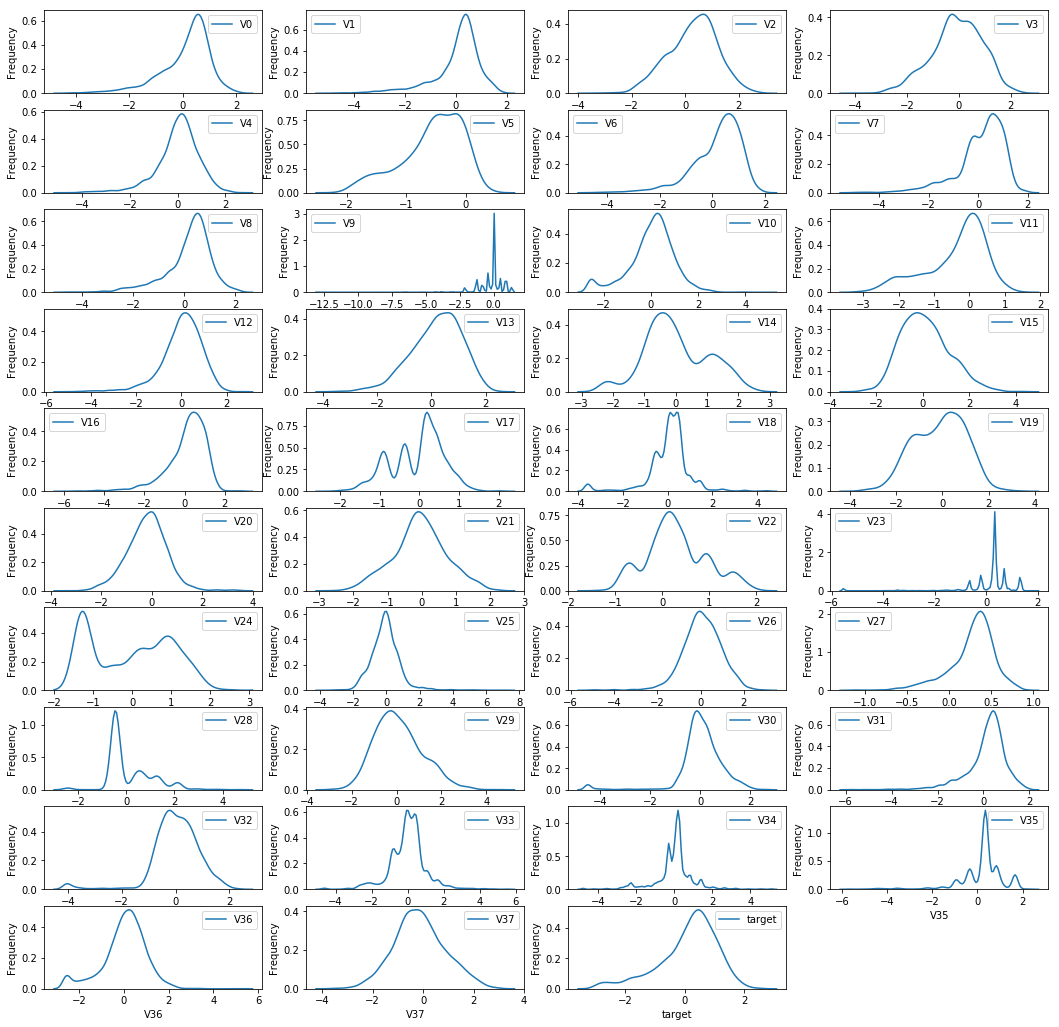

In [5]:
plt.figure(figsize=(18, 18)) 

for column_index, column in enumerate(train_data0.columns):
    plt.subplot(10, 4, column_index + 1)
    g=sns.kdeplot(train_data0[column])
    g.set_xlabel(column)
    g.set_ylabel('Frequency')

# 特征相关性

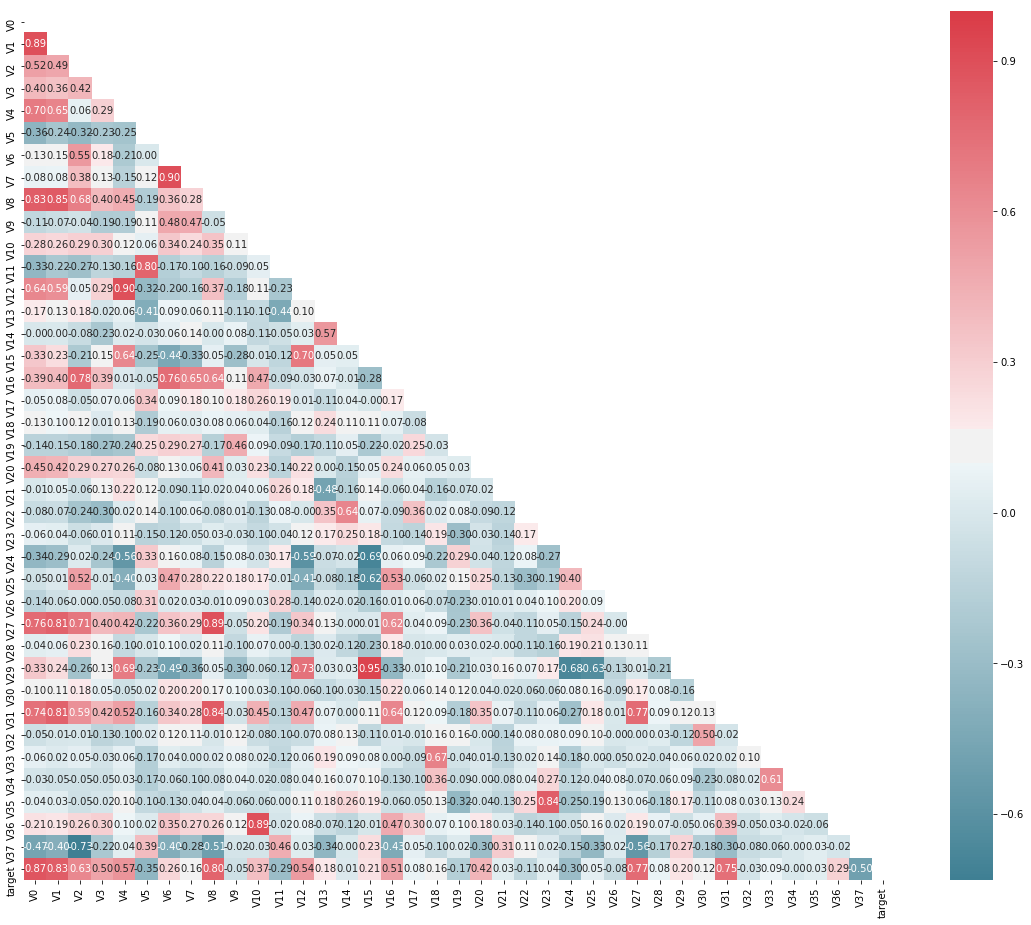

target    1.000000
V0        0.866709
V1        0.832457
V8        0.799280
V27       0.765133
V31       0.749034
V2        0.630160
V4        0.574775
V12       0.542429
V16       0.510025
V3        0.501114
V37       0.497162
V20       0.420424
V10       0.371067
V5        0.345683
V24       0.296056
V11       0.293261
V36       0.287696
V6        0.264778
V15       0.213490
V29       0.198244
V13       0.177317
V19       0.171120
V7        0.164981
V18       0.162710
V30       0.123423
V22       0.112248
Name: target, dtype: float64
          target        V0        V1        V8       V27       V31        V2  \
target  1.000000  0.866709  0.832457  0.799280  0.765133  0.749034  0.630160   
V0      0.866709  1.000000  0.894256  0.831926  0.763410  0.738433  0.517319   
V1      0.832457  0.894256  1.000000  0.848793  0.807414  0.806790  0.490908   
V8      0.799280  0.831926  0.848793  1.000000  0.886859  0.841188  0.676597   
V27     0.765133  0.763410  0.807414  0.886859  1.000000  

In [6]:
plt.figure(figsize=(20, 16)) 
colnm = train_data0.columns.tolist() 
mcorr = train_data0[colnm].corr(method="spearman") 
mask = np.zeros_like(mcorr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f') 
plt.show()

mcorr=mcorr.abs()
numerical_corr=mcorr[mcorr['target']>0.1]['target']
print(numerical_corr.sort_values(ascending=False))
index0 = numerical_corr.sort_values(ascending=False).index
print(train_data0[index0].corr('spearman'))

自变量与目标变量相关性绝对值0.1以上的有：
V0,V1,V2,V3,V4,V5,V6,V7,V8,V10,V11,V12,V13,V15,V16,V18,V19,V20,V22,V23,V24,V27,V29,V30,V31,V36,V37

自变量相关性0.8以上的有：
V0: V1 V8 ;
V1: V8 V27 V31;
V4: V12;
V5: V11;
V6: V7;
V8: V27 V31 ;
V10: V36;
V15: V29;
V23: V35;

于是，选取特征自变量与目标变量相关性绝对值0.1以上并且剔除高度相关性的自变量。

In [7]:
train_data1=train_data0[['V1','V2','V3','V4','V5','V6','V10','V13','V15',
                         'V16','V18','V19','V20','V22','V23','V24','V30','V37','target']]
train_data1.head()

,V1,V2,V3,V4,V5,V6,V10,V13,V15,V16,V18,V19,V20,V22,V23,V24,V30,V37,target
0,0.016,-0.143,0.407,0.452,-0.901,-1.812,-0.940,0.550,0.000,-1.707,-0.573,-0.991,0.610,-0.063,0.356,0.800,0.109,-3.508,0.175
1,0.437,0.066,0.566,0.194,-0.893,-1.566,0.188,1.109,0.000,-0.977,-0.571,-0.836,0.588,-0.063,0.357,0.801,0.124,-0.730,0.676
2,0.568,0.235,0.370,0.112,-0.797,-1.367,0.874,0.767,-0.212,-0.618,-0.564,-0.558,0.576,-0.063,0.355,0.961,0.361,-0.589,0.633
3,0.368,0.283,0.165,0.599,-0.679,-1.200,0.011,0.769,-0.162,-0.429,-0.574,-0.564,0.272,-0.063,0.352,1.435,0.417,-0.112,0.206
4,0.638,0.260,0.209,0.337,-0.454,-1.073,-0.251,-0.349,-0.138,-0.391,-0.572,-0.394,0.106,-0.259,0.352,0.881,1.078,-0.028,0.384


# 多重共线性

In [8]:
new_numerical=['V1','V2','V3','V4','V5','V6','V10','V13','V15',
'V16','V18','V19','V20','V22','V23','V24','V30','V37']
X=np.matrix(train_data1[new_numerical])
VIF_list=[variance_inflation_factor(X, i) for i in range(X.shape[1])]
VIF_list

[4.022395550356531,
 8.239128641236116,
 1.642000694371818,
 3.927282997385259,
 2.157100276807654,
 5.3472633494262745,
 1.7299591336932452,
 1.8315761158812087,
 3.11511186938201,
 9.926503438916924,
 1.6639075679486477,
 1.5321128873724277,
 1.4665430621660969,
 1.556532800640334,
 1.6171543940768818,
 2.2201322880495677,
 1.5190591516247698,
 4.31939290902516]

多重共线性不明显，暂不需要进一步降维处理。为了降低个别特征较大波动，有可能造成不同特征权重系数变化过大，将数据进行z-score标准化。

In [9]:
train0=train_data1.iloc[:,0:-1]
test0=test_data0[['V1','V2','V3','V4','V5','V6','V10','V13','V15',
'V16','V18','V19','V20','V22','V23','V24','V30','V37']]
target=train_data1.iloc[:,-1]
train=(train0-np.mean(train0,axis=0))/np.std(train0,axis=0)
test=(test0-np.mean(test0,axis=0))/np.std(test0,axis=0)

预测模型探索

In [10]:
train_data,test_data,train_target,test_target=train_test_split(train,target,test_size=0.2,random_state=0)
m=RandomForestRegressor()
m.fit(train_data, train_target)
score=mean_squared_error(test_target,m.predict(test_data))
print(score)

0.14805494825259513


多次重复，查看模型预测结果的稳定性

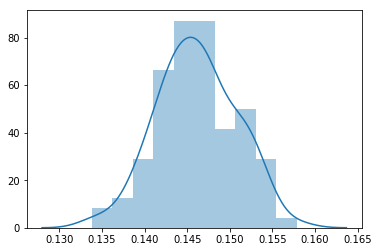

In [13]:
model_accuracies = []

for repetition in range(100):
    train_data,test_data,train_target,test_target=train_test_split(train,target,test_size=0.2,random_state=0)

    m=RandomForestRegressor()
    m.fit(train_data, train_target)
    score=mean_squared_error(test_target,m.predict(test_data))
    model_accuracies.append(score)

sns.distplot(model_accuracies)

模型参数调优

In [14]:
param_grid = {'n_estimators':[1,5,10,25,50,100],'max_features':('auto','sqrt','log2')}
m = GridSearchCV(RandomForestRegressor(),param_grid)
m=m.fit(train_data,train_target)
score=mean_squared_error(test_target,m.predict(test_data))
print(score)
print(m.best_score_)
print(m.best_params_)

m = RandomForestRegressor(n_estimators=100,max_features='log2')
m.fit(train_data, train_target)
predict = m.predict(test)
np.savetxt('./submit/njit_77.txt',predict)

0.13301742012283735
0.8639308164089233
{'max_features': 'log2', 'n_estimators': 100}
